# FitARMA Package

### Cargamos las librerías y los datos

In [47]:
library(forecast)
library(ggplot2)
library(zoo)
library(rdatamarket)

library(FitARMA)

Warning message:
"package 'FitARMA' was built under R version 3.3.3"Loading required package: FitAR
Warning message:
"package 'FitAR' was built under R version 3.3.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.3.3"Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.3.3"Loading required package: ltsa
Loading required package: bestglm
Warning message:
"package 'bestglm' was built under R version 3.3.3"
Attaching package: 'FitAR'

The following object is masked from 'package:forecast':

    BoxCox



In [51]:
acc <- as.ts(dmseries('http://data.is/1yFXOBi'))

In [49]:
# Función genérica para plotting de test vs pred a través de ggplot2
combine <- function(test, pred) {
  require(ggplot2)
  p <- ggplot() +
    geom_line(aes(x = index(as.zoo(test)), y = coredata(as.zoo(test)), colour = 'Test')) +
    geom_line(aes(x = index(as.zoo(test)), y = pred, colour = 'Prediccion')) +
    scale_color_manual(name = '', values = c('Test' = 'black', 'Prediccion' = 'red'),
                       labels = c('Test','Predicción'))
  p
}

<br>

### Ajustamos estacionalmente la serie, diferenciamos y volvemos a dividir en dos conjuntos

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


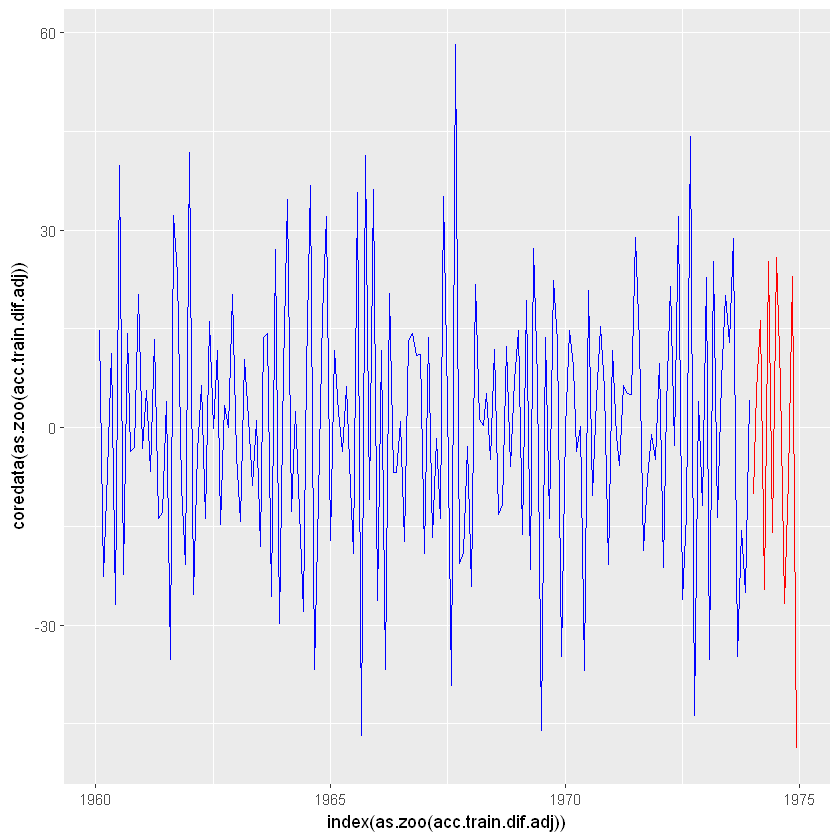

In [53]:
decomposition <- decompose(accidentes, type = 'additive')
accidentes.adj <- seasadj(decomposition) # Forecast

# Diferenciamos
accidentes.dif.adj <- diff(accidentes.adj) 
acc.train.dif.adj <- window(accidentes.dif.adj, start = c(1960,2), end = c(1973,12)) # Perdemos una observación
acc.test.dif.adj <- window(accidentes.dif.adj, start = c(1974,1))

# Plotting
p <- ggplot() +
  geom_line(aes(x = index(as.zoo(acc.train.dif.adj)), y = coredata(as.zoo(acc.train.dif.adj))), col = 'blue') +
  geom_line(aes(x = index(as.zoo(acc.test.dif.adj)), y = coredata(as.zoo(acc.test.dif.adj))), col = 'red')
p

<br>

### Estudiamos los correlogramas para ajustar un ARIMA

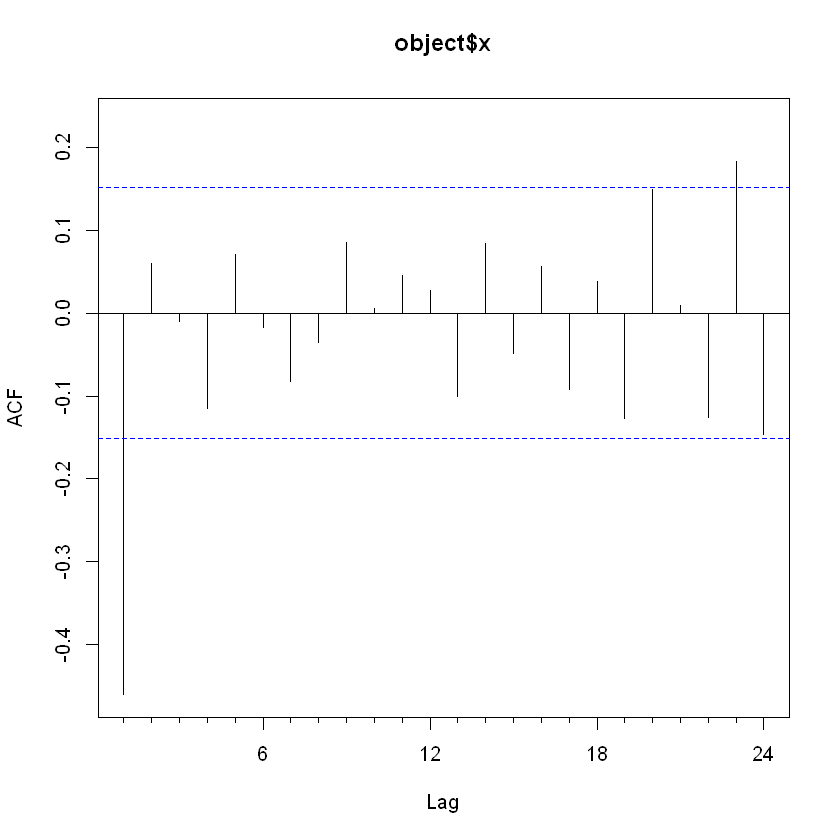

In [54]:
Acf(acc.train.dif.adj)

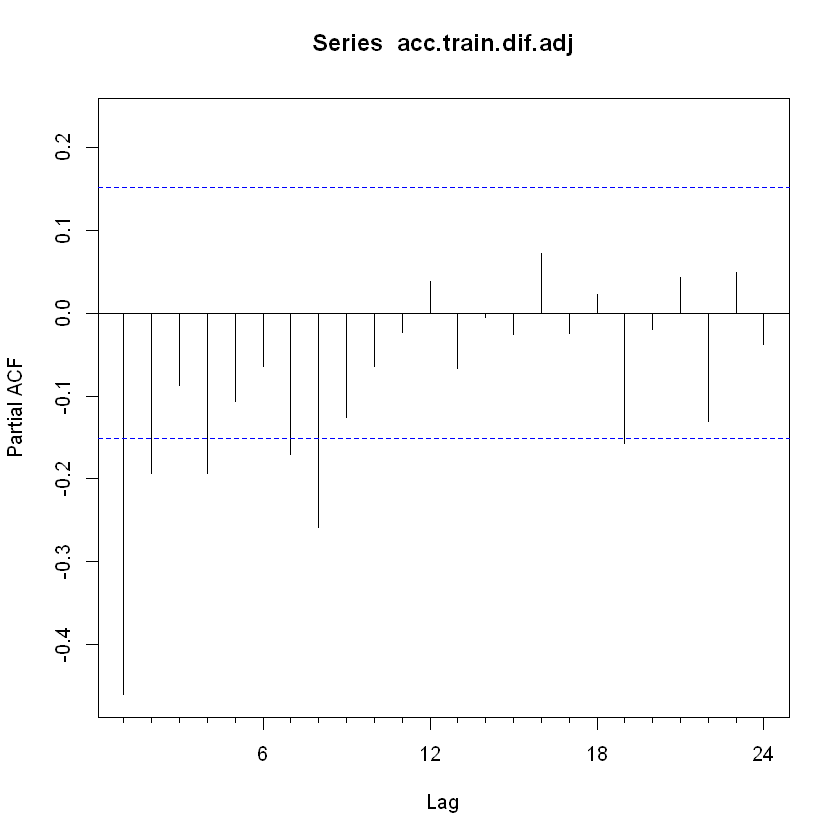

In [55]:
Pacf(acc.train.dif.adj)

<br>

### Ajustamos un ARIMA(2,1,1)

In [56]:
model.2 <- FitARMA(z = acc.train.dif.adj, order = c(2,0,1), MeanMLEQ =  TRUE)
summary(model.2) # AIC = 938.5  Loglikelihood = -465.27

ARIMA(2,0,1)  With mean MLE.
length of series = 167 ,  number of parameters = 4
loglikelihood = -465.27 ,  aic = 938.5 ,  bic =  951


In [57]:
coef(model.2)

,MLE,sd,Z-ratio
phi(1),0.2281884,0.08176180,2.79089249
phi(2),0.1438438,0.08108491,1.77398937
theta(1),0.9591174,0.02550060,37.61156596
mu,0.4039298,8.05657940,0.05013664


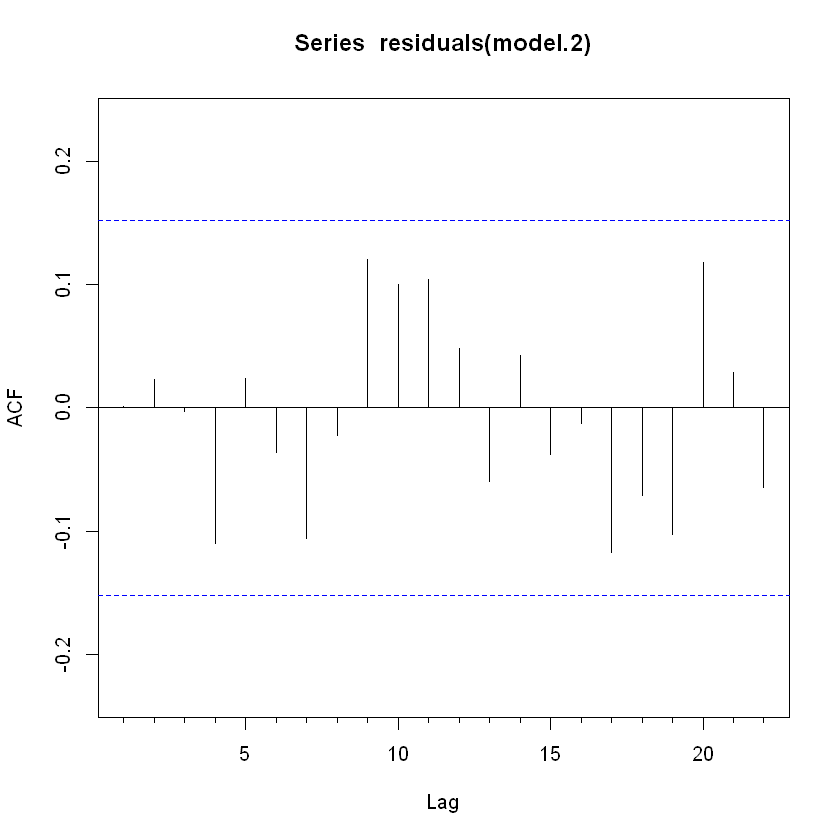

In [58]:
Acf(residuals(model.2))

In [60]:
model.2$LjungBoxQ

,m,Qm,pvalue
,1,0.00,0.9865362
,2,0.09,0.7627634
,3,0.09,0.7612876
,4,2.17,0.1407892
,5,2.27,0.3214096
,6,2.50,0.4753507
,7,4.47,0.3459710
,8,4.56,0.4716461
,9,7.13,0.3088292
,10,8.92,0.2582565


Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


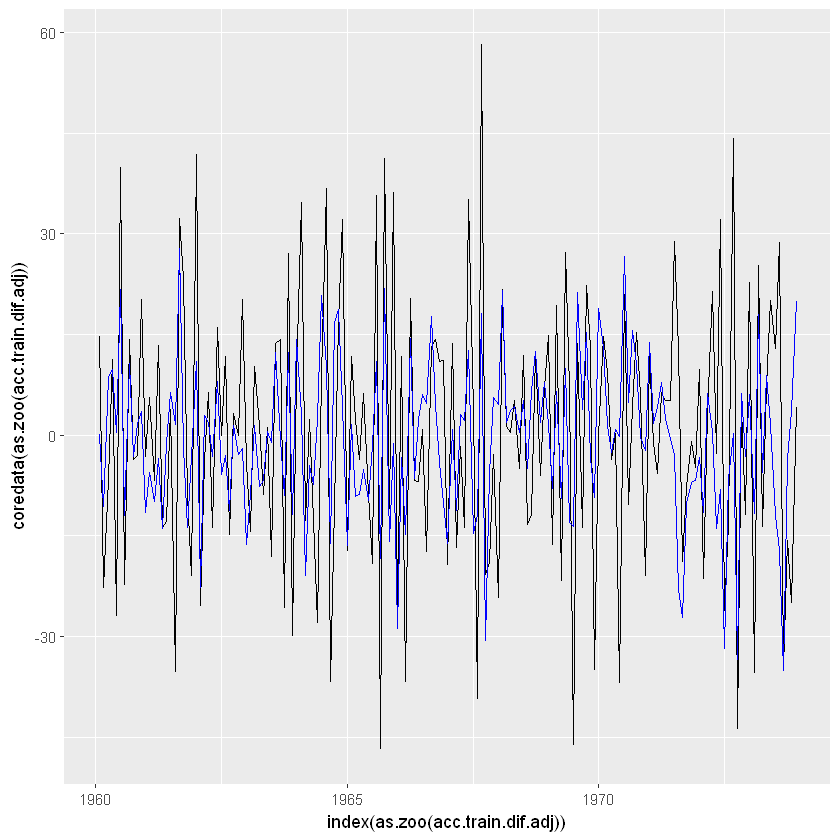

In [61]:
p <- ggplot() +
  geom_line(aes(x = index(as.zoo(acc.train.dif.adj)),
                y = coredata(as.zoo(acc.train.dif.adj))), col = 'black') +
  geom_line(aes(x = index(as.zoo(fitted(model.2))), y = coredata(as.zoo(fitted(model.2)))), col = 'blue')
p

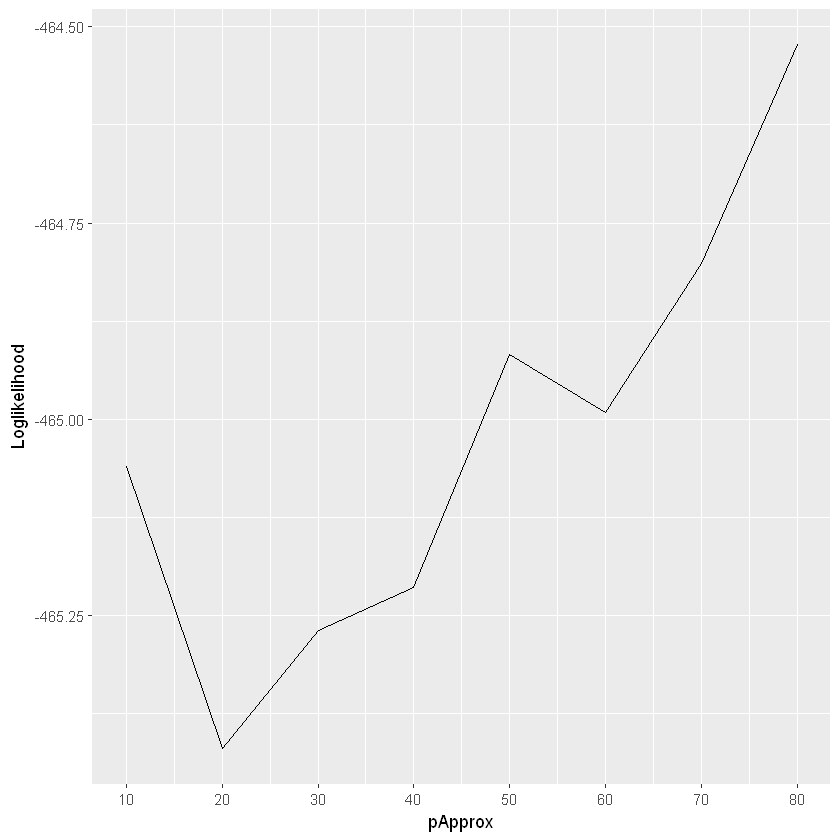

In [62]:
# Jugando con pApprox
pApprox.metrics <- c()
pApprox.values <- seq(10, 80, 10)

for (i in pApprox.values) {
  model <- FitARMA(acc.train.dif.adj, order = c(2,0,1), MeanMLEQ = TRUE, pApprox = i)
  pApprox.metrics <- c(pApprox.metrics, model$loglikelihood)
}
pApp <- data.frame(pApprox = pApprox.values, LogLikelihood = pApprox.metrics)

p <- ggplot() +
  geom_line(data = pApp, aes(x = pApprox, y = LogLikelihood)) +
  xlab('pApprox') + ylab('Loglikelihood') +
  scale_x_continuous(breaks = pApprox.values)
p

<br>

### Ajustamos un ARIMA(2,1,1) con MeanMLEQ = TRUE

In [63]:
model.3 <- FitARMA(acc.train.dif.adj, order = c(2,0,1), MeanMLEQ =  TRUE, pApprox = 80)
summary(model.3) # AIC = 937  Loglikelihood = -464.52

ARIMA(2,0,1)  With mean MLE.
length of series = 167 ,  number of parameters = 4
loglikelihood = -464.52 ,  aic = 937 ,  bic =  949.5


In [64]:
coef(model.3)

,MLE,sd,Z-ratio
phi(1),0.2466925,0.07792543,3.16575124
phi(2),0.1667451,0.07784360,2.14205329
theta(1),0.9859370,0.01368159,72.06306074
mu,0.3643851,10.53794494,0.03457838


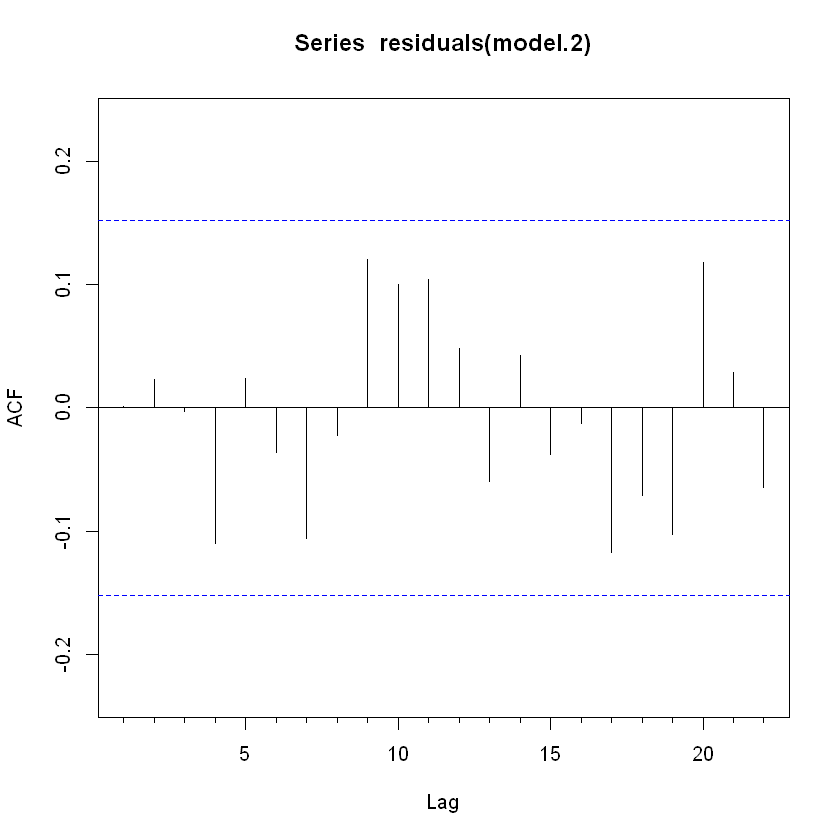

In [65]:
Acf(residuals(model.2))

In [66]:
model.3$LjungBoxQ

,m,Qm,pvalue
,1,0.00,0.9628377
,2,0.06,0.8097942
,3,0.08,0.7720338
,4,1.57,0.2102370
,5,1.81,0.4053848
,6,1.90,0.5939870
,7,3.67,0.4519726
,8,3.71,0.5919510
,9,6.66,0.3537382
,10,8.67,0.2769773
